# Interaction Term Exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import statsmodels.formula.api as smf

import requests as re

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

sns.set_context('poster')
sns.set_style('whitegrid')

In [2]:
df = pd.read_json('./rawData/cleaned.json')
df.columns

Index(['Balcony', 'Cats_Allowed', 'Common_Outdoor_Space', 'Dining_Room',
       'Dishwasher', 'Dogs_Allowed', 'Doorman', 'Elevator', 'Exclusive',
       'Fitness_Center', 'Garden_Patio', 'Hardwood_Floors',
       'High_Speed_Internet', 'Laundry_in_Unit', 'Loft', 'New_Construction',
       'No_Fee', 'Outdoor_Space', 'Pre_War', 'Roof_Deck', 'Swimming_Pool',
       'Terrace', 'Wheelchair_Access', 'bathrooms', 'bedrooms', 'building_id',
       'created', 'description', 'display_address', 'features', 'interestVal',
       'interest_level', 'latitude', 'laundry_in_building', 'listing_id',
       'longitude', 'manager_id', 'price', 'street_address'],
      dtype='object')

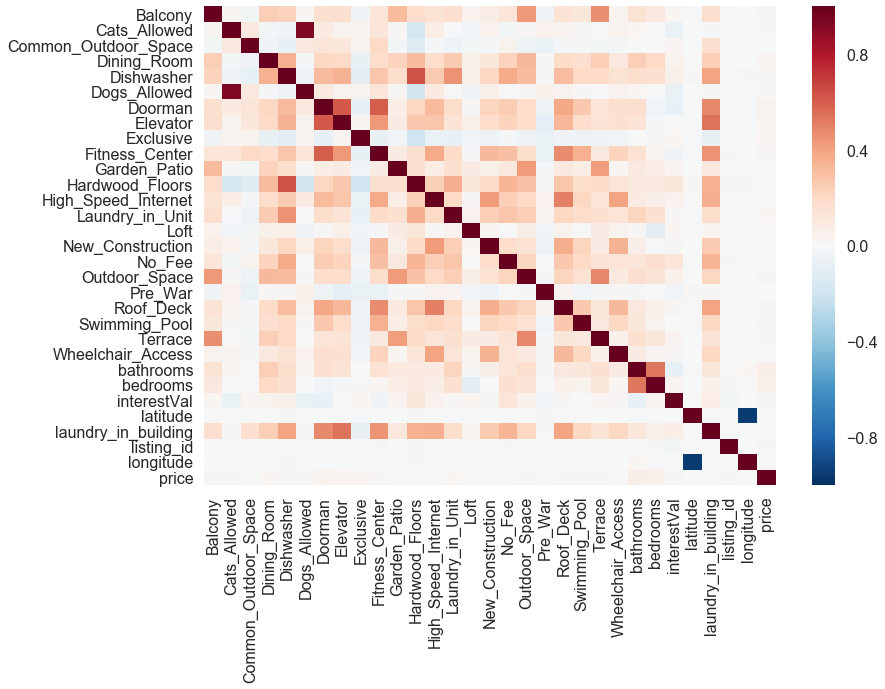

In [3]:
# Correlation Matrix of Data
sns.heatmap(df.corr())

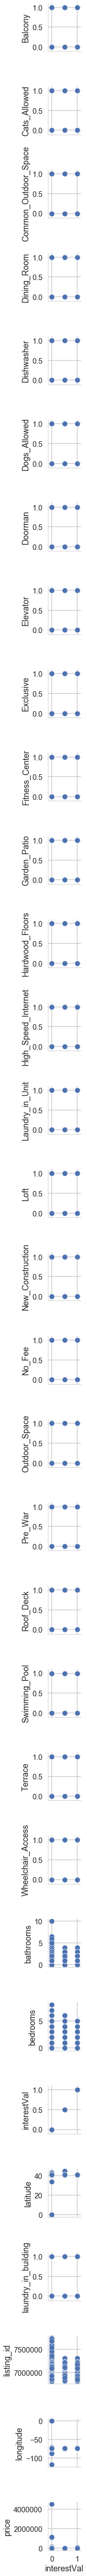

In [4]:
# See if we can get spread of interest level by different predictors
cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(df, x_vars=['interestVal'], y_vars=cols)
plt.savefig('interestLevelPairwise.png')

Seems like fewer number of bedrooms and bathrooms indicates medium and high interest listings.

In [5]:
# Create interaction term for cats and dogs allowed
# 1 if both are allowed, 0 if one or neither are allowed
df['pets_allowed'] = df['Cats_Allowed'] * df['Dogs_Allowed']

In [6]:
# Create interaction term for doorman/exclusive
# 1 if both are included, 0 if one or neither are included
df['door_excl'] = df['Doorman'] * df['Exclusive']

In [7]:
# Create interaction term for fitness oriented
# 1 if both swimming pool and fitness center are included, 0 if one or neither included
df['fitness_oriented'] = df['Fitness_Center'] * df['Swimming_Pool']

In [8]:
# Create transformed term that creates a score for outdoor spaces
# Higher the score, the more of these features are included
df['outdoor_score'] = (df['Outdoor_Space'] + df['Balcony'] + df['Common_Outdoor_Space'] 
                       + df['Garden_Patio'] + df['Roof_Deck'] + df['Terrace']) / 6

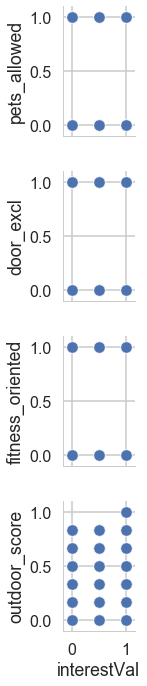

In [9]:
# Interest level vs. new interaction terms
sns.pairplot(df, x_vars=['interestVal'], y_vars=['pets_allowed', 'door_excl', 'fitness_oriented', 'outdoor_score'])

Only high interest listings have all 6 outdoor features.  So if a listing does not have a balcony, common outdoor space, garden/patio, roof deck, or terrace, then we know it is not high interest.

In [10]:
# ADA compatible interaction term
# 1 if both elevator and wheelchair access, 0 if one or neither are included
df['ada'] = df['Elevator'] * df['Wheelchair_Access']

In [11]:
# Luxury Score Term - higher the score means the more luxury items included
df['lux_score'] = (df['Exclusive'] + df['Doorman'] + df['Outdoor_Space'] + df['New_Construction'] + df['Roof_Deck'] + df['Fitness_Center'] + df['Swimming_Pool'] + df['Elevator'] + df['Laundry_in_Unit'] + df['Hardwood_Floors']) / 10

In [12]:
def count_features(feats):
    return len(feats)

In [13]:
# Number of Features per Listing
df['num_features'] = df['features'].apply(lambda x: count_features(x))

In [15]:
# Number of Luxury Features Term
df['num_luxury'] = df['Exclusive'] + df['Doorman'] + df['Outdoor_Space'] + df['New_Construction'] + df['Roof_Deck'] + df['Fitness_Center'] + df['Swimming_Pool'] + df['Elevator'] + df['Laundry_in_Unit'] + df['Hardwood_Floors']

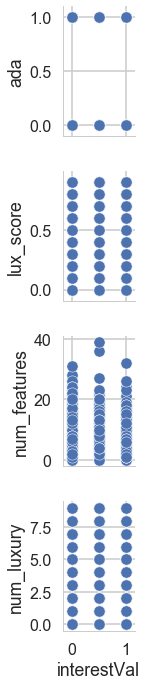

In [18]:
# Interest level vs. new interaction terms
sns.pairplot(df, x_vars=['interestVal'], y_vars=['ada', 'lux_score', 'num_features', 'num_luxury'])

It is interesting that a higher number of features doesn't seem to indicate more interest.  The highest number of features indicate medium amount of interest.  All interest levels seems to have these "luxury features" so maybe these aren't good indications of luxury.

The number of luxuries a listing has does not tell us anything about the interest level.  High values of price per number of luxuries seems to indicate low interest listings.  Price per number of luxuries seems inconclusive for medium versus high interest levels.

In [17]:
# Export Interaction Terms to Data File
df.to_json('./typedData/withInteraction.json')

# Try Some Models with Interaction Terms

In [19]:
# Split into a training and a test set from training data
X_tr, X_test, Y_tr, Y_test = train_test_split(df, df['interestVal'], test_size=0.3, random_state=42)
print('Num Rows in X Training Set = %s' % len(X_tr))
print('Num Rows in Y Training Set = %s' % len(Y_tr))
print('Num Rows in X Test Set = %s' % len(X_test))
print('Num Rows in Y Test Set = %s' % len(Y_test))

Num Rows in X Training Set = 29342
Num Rows in Y Training Set = 29342
Num Rows in X Test Set = 12576
Num Rows in Y Test Set = 12576


## Linear Regression

In [20]:
# Run linear regression with interaction terms (exluding non-numeric terms)
# Can compare with linear regression without interaction terms in Braden Linear.ipynb file
X_tr_wo_obj = X_tr.select_dtypes(exclude=['object'])
equation = ('+').join(X_tr_wo_obj.drop(['listing_id','interestVal'], axis=1).columns)
model = smf.ols('interestVal~'+equation, data=X_tr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            interestVal   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     60.43
Date:                Sun, 03 Dec 2017   Prob (F-statistic):               0.00
Time:                        13:59:39   Log-Likelihood:                -6551.7
No. Observations:               29342   AIC:                         1.317e+04
Df Residuals:                   29307   BIC:                         1.346e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1409      0.101      1.395      0.163      -0.057       0.339
Balcony                  0.0051      0.009      0.583      0.560      -0.012       0.022
Cats_Allowed             0.0321      0.010      3.068      0.002       0.012       0.053
Common_Outdoor_Space     0.1008      0.012      8.552      0.000       0.078       0.124
Dining_Room              0.0088      0.007      1.306      0.192      -0.004       0.022
Dishwasher              -0.0065      0.005     -1.217      0.224      -0.017       0.004
Dogs_Allowed             0.1446      0.061      2.383      0.017       0.026       0.264
Doorman                 -0.0696      0.006    -11.690      0.000      -0.081      -0.058
Elevator                -0.0050      0.006     -0.894      0.371      -0.016       0.006
Exclusive                0.0684      0.009      7.222      0.000       0.050       0.087
Fitness_Center          -0.0376      0.006     -6.221      0.000      -0.050      -0.026
Garden_Patio             0.0062      0.010      0.588      0.557      -0.014       0.027
Hardwood_Floors          0.0583      0.005     10.974      0.000       0.048       0.069
High_Speed_Internet      0.0461      0.008      5.674      0.000       0.030       0.062
Laundry_in_Unit         -0.0174      0.006     -2.926      0.003      -0.029      -0.006
Loft                     0.0134      0.009      1.478      0.139      -0.004       0.031
New_Construction        -0.0058      0.009     -0.639      0.523      -0.024       0.012
No_Fee                   0.0736      0.004     16.432      0.000       0.065       0.082
Outdoor_Space            0.0216      0.007      2.936      0.003       0.007       0.036
Pre_War                 -0.0364      0.005     -7.683      0.000      -0.046      -0.027
Roof_Deck               -0.0107      0.007     -1.553      0.120      -0.024       0.003
Swimming_Pool           -0.0032      0.023     -0.142      0.887      -0.048       0.041
Terrace                  0.0007      0.010      0.064      0.949      -0.020       0.021
Wheelchair_Access        0.1295      0.091      1.417      0.156      -0.050       0.309
bathrooms               -0.0696      0.004    -15.765      0.000      -0.078      -0.061
bedrooms                 0.0157      0.002      7.943      0.000       0.012       0.020
latitude                 0.0062      0.009      0.694      0.488      -0.011       0.024
laundry_in_building      0.0500      0.005      9.709      0.000       0.040       0.060
longitude                0.0021      0.005      0.431      0.666      -0.007       0.011
price                -1.847e-06   2.55e-07     -7.233      0.000   -2.35e-06   -1.35e-06
pets_allowed            -0.1953      0.062     -3.173      0.002      -0.316      -0.075
door_excl               -0.0732      0.020     -3.652    

In [21]:
X_test_wo_obj = X_test.select_dtypes(exclude=['object'])
X_test_wo_obj = X_test_wo_obj.drop(['interestVal'],axis=1)
print('Test MSE for OLS = %s' % mean_squared_error(Y_test, model.predict(X_test_wo_obj)))

Test MSE for OLS = 0.0975635153999


With interaction terms we get some improvement over the linear regression without interaction terms.  The $R^2$ value with interaction terms is 0.066 whereas without interaction terms the $R^2$ is 0.024.

## Ridge Regression with Interaction Terms

The optimal lambda for ridge regression is 0.434874501309


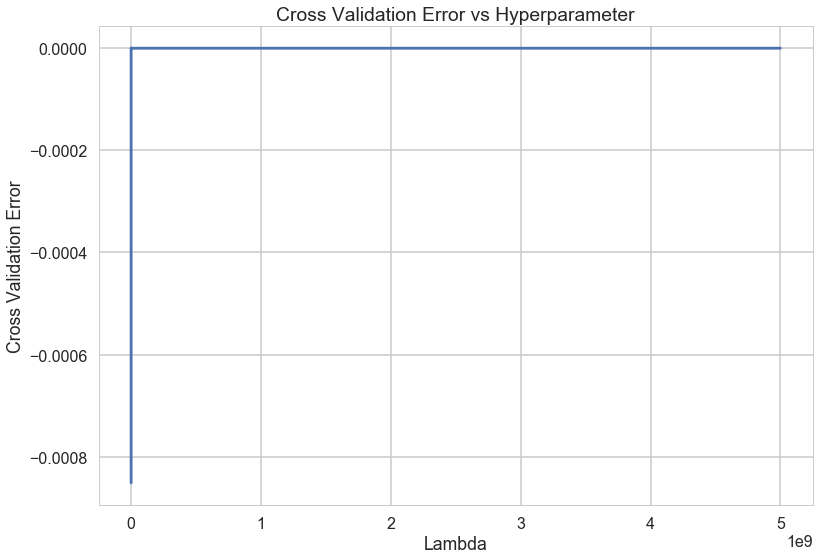

In [22]:
# Find best lambda for ridge regression
lambdas = 10**np.linspace(10, -2, 100) * 0.5
ridgecv = RidgeCV(alphas=lambdas, scoring='neg_mean_squared_error', normalize=True, store_cv_values=True)
X_tr_wo_obj = X_tr_wo_obj.drop(['interestVal'], axis=1)
ridgecv.fit(X_tr_wo_obj, Y_tr)
print('The optimal lambda for ridge regression is %s' % ridgecv.alpha_)
mean_errors = np.mean(ridgecv.cv_values_, axis=0)

plt.plot(lambdas, mean_errors)
plt.title('Cross Validation Error vs Hyperparameter')
plt.xlabel('Lambda')
plt.ylabel('Cross Validation Error')

In [23]:
# Run Ridge regression on test data
ridge = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge.fit(X_tr_wo_obj, Y_tr)
print('Test MSE for ridge regression = %s' % mean_squared_error(Y_test, ridge.predict(X_test_wo_obj)))

Test MSE for ridge regression = 0.0965080725649


This test MSE for ridge is almost identical to the test MSE for OLS.  This means that using ridge regression does not provide a better model than linear regression.

In [24]:
preds_ridge = ridge.predict(X_test_wo_obj)
interst_level = X_test['interest_level']
clf_ridge = pd.DataFrame([preds_ridge, interst_level], index ={'prediction','interest'}).transpose()

ValueError: could not convert string to float: 'low'

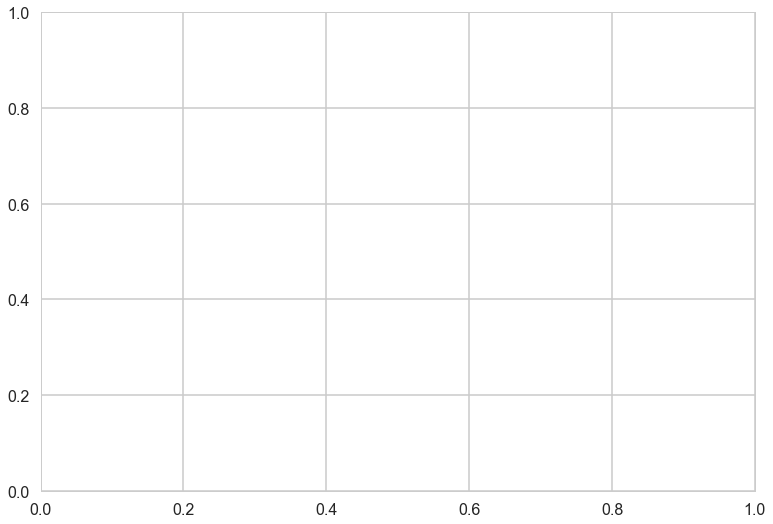

In [25]:
for i in clf_ridge['interest'].unique():
    plt.plot(clf_ridge[clf_ridge['interest']==i]['prediction'], '.')

The above graph depicts the predicted values with our model, hued by their true interest level.  Note, our model maps to "interest values" i.e. a number which we need to map back to low, medium, and high.  It is apparent that there is no accurate way to split the predictions into the three interest levels because there is no clustering.  Therefore, ridge regression on top of interaction terms does not seem like a good model.

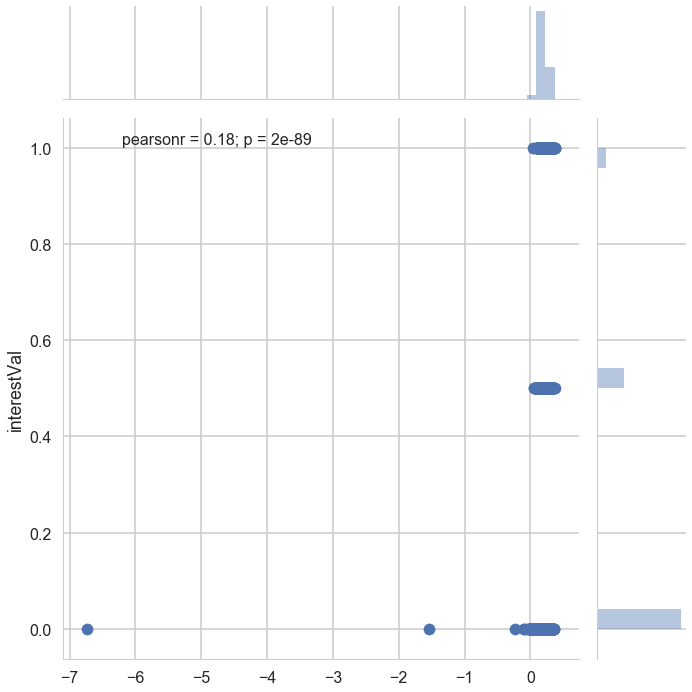

In [137]:
sns.jointplot(preds, Y_test, size=10)

In [80]:
def interestLevelMap(x):
    if x < .33:
        return 'low'
    elif x < .66:
        return 'medium'
    else:
        return 'high'

In [81]:
df['interest_level'].value_counts()

low       29147
medium     9491
high       3280
Name: interest_level, dtype: int64

In [82]:
preds = ridge.predict(X_test_wo_obj)
clf = [interestLevelMap(x) for x in preds]

In [84]:
print(classification_report(clf, df['interest_level'][Y_test.index]))

             precision    recall  f1-score   support

       high       0.00      0.00      0.00         0
        low       1.00      0.70      0.82     12532
     medium       0.01      0.32      0.01        44

avg / total       0.99      0.70      0.82     12576



C:\Users\BrookeB\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [85]:
print(confusion_matrix(clf, df['interest_level'][Y_test.index]))

[[   0    0    0]
 [ 989 8763 2780]
 [  13   17   14]]


## Lasso with Interaction Terms

The optimal lambda for lasso is 0.000220836116463


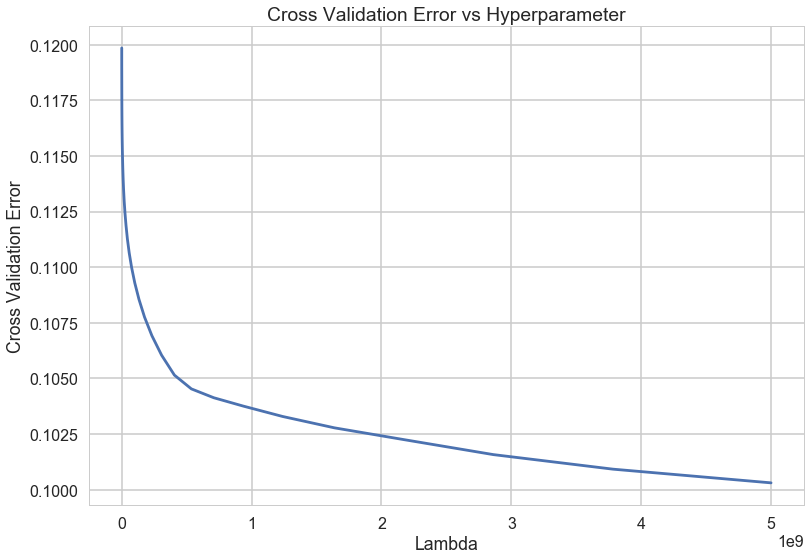

In [26]:
# Find best lambda for Lasso Regression
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_tr_wo_obj, Y_tr)
print('The optimal lambda for lasso is %s' % lassocv.alpha_)
mean_errors_cv = np.mean(lassocv.mse_path_, axis=1)

plt.plot(lambdas, mean_errors_cv)
plt.title('Cross Validation Error vs Hyperparameter')
plt.xlabel('Lambda')
plt.ylabel('Cross Validation Error')

In [27]:
# Fit model with Lasso 
lasso = Lasso(max_iter=10000, normalize=True)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_tr_wo_obj, Y_tr)
print('Test MSE for lasso = %s' % mean_squared_error(Y_test, lasso.predict(X_test_wo_obj)))

Test MSE for lasso = 0.0988294211151


ValueError: could not convert string to float: 'low'

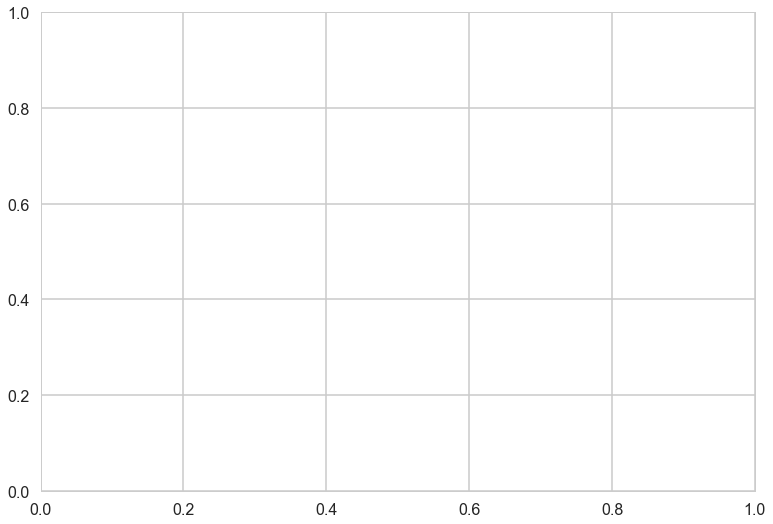

In [85]:
preds_lasso = lasso.predict(X_test_wo_obj)
clf_lasso = pd.DataFrame([preds_lasso, interst_level], index ={'prediction','interest'}).transpose()
for i in clf_lasso['interest'].unique():
    plt.plot(clf_lasso[clf_lasso['interest']==i]['prediction'], '.')

The above graph depicts the predicted values with our model, hued by their true interest level.  Note, our model maps to "interest values" i.e. a number which we need to map back to low, medium, and high.  It is apparent that there is no accurate way to split the predictions into the three interest levels because there is no clustering.  Therefore, lasso on top of interaction terms does not seem like a good model.